In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [2]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 65034/65034 [01:44<00:00, 624.68it/s]


In [3]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 64629
Num labels EPOC: 11
Labels EPOC: ['6', '3', '2', '8', '-1', '9', '1', '4', '5', '0', '7']
------------------------------------
Data shape EPOC (256, 14)


In [4]:
for point in tqdm(all_points):
    point.full_clean(channels=['T7', 'P7', 'P8', 'T8'])

100%|██████████| 64629/64629 [03:47<00:00, 284.71it/s]


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from models.EegClassifierA import Classifier
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from EegHelper.EegAugmentation import NormalizationHelper, EegGaussianNoise, EegRandomScaling

%matplotlib inline

https://github.com/vlawhern/arl-eegmodels

https://github.com/SuperBruceJia/EEG-DL

https://github.com/SuperBruceJia/EEG-Motor-Imagery-Classification-CNNs-TensorFlow

In [ ]:
train_points, test_points = train_test_split(all_points, train_size=0.8, shuffle=True)

helper = NormalizationHelper(train_points)           #Provide the data which you want to fit with
scaler = helper.get_standard_scaler()              #Get the fit scaler

train_points = NormalizationHelper.fit_points(scaler, train_points) #Fit points after providing scaler
test_points = NormalizationHelper.fit_points(scaler, test_points) #Fit points after providing scaler

In [18]:
transforms = nn.Sequential(
    EegGaussianNoise(mu = 0, sigma = 1),
    EegRandomScaling(mu=1, sigma=0.1)
)

batch_size = 32
num_workers = 4

dataset_train = EegDataset(data_points=train_points, labels=all_labels, transforms = transforms)
dataset_test = EegDataset(data_points=test_points, labels=all_labels)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = Classifier().to(device=device)

optimizer = Adam(model.parameters(), lr=0.0001)                                           
loss_function = CrossEntropyLoss()

n_epochs = 100

validation_data = []
training_data = []

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()

    train_loss = 0.0
    train_accuracy = 0.0

    for data, labels in tqdm(train_dataloader):
        
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        #Loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*data.size(0)

        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy+=int(torch.sum(prediction==expected_prediction))        
        
    
    train_loss/=(len(train_dataloader))
    train_accuracy/=(len(train_dataloader) * batch_size)
    training_data.append(train_loss.item())

    print('Epoch train loss:', train_loss.item())
    print('Epoch accuracy:', train_accuracy)

    print("------------------Validating--------------------")
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy+=int(torch.sum(prediction==expected_prediction))        
        #Loss
        val_loss += loss_function(outputs, labels)*data.size(0)

    val_loss /= len(test_dataloader)
    val_accuracy /= (len(test_dataloader)*batch_size)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())
    print('Validation accuracy:',val_accuracy)

cuda
Epoch 1/100


100%|██████████| 1616/1616 [00:06<00:00, 243.65it/s]

Epoch train loss: 76.47929382324219
Epoch accuracy: 0.10146581064356436
------------------Validating--------------------


Validation loss: 76.47708129882812
Validation accuracy: 0.09545173267326733
Epoch 2/100


100%|██████████| 1616/1616 [00:06<00:00, 233.64it/s]

Epoch train loss: 76.45520782470703
Epoch accuracy: 0.10040222772277228
------------------Validating--------------------


Validation loss: 76.46925354003906
Validation accuracy: 0.10403774752475248
Epoch 3/100


100%|██████████| 1616/1616 [00:06<00:00, 233.94it/s]


Epoch train loss: 76.44657135009766
Epoch accuracy: 0.10394105816831684
------------------Validating--------------------
Validation loss: 76.44933319091797
Validation accuracy: 0.10032487623762376
Epoch 4/100


100%|██████████| 1616/1616 [00:06<00:00, 232.83it/s]

Epoch train loss: 76.43580627441406
Epoch accuracy: 0.10481126237623763
------------------Validating--------------------


Validation loss: 76.4587173461914
Validation accuracy: 0.09754022277227722
Epoch 5/100


100%|██████████| 1616/1616 [00:07<00:00, 226.55it/s]

Epoch train loss: 76.42374420166016
Epoch accuracy: 0.10564279084158416
------------------Validating--------------------


Validation loss: 76.4296875
Validation accuracy: 0.10086633663366337
Epoch 6/100


100%|██████████| 1616/1616 [00:07<00:00, 227.54it/s]

Epoch train loss: 76.40459442138672
Epoch accuracy: 0.10674504950495049
------------------Validating--------------------


Validation loss: 76.40625762939453
Validation accuracy: 0.10968440594059406
Epoch 7/100


100%|██████████| 1616/1616 [00:07<00:00, 228.75it/s]

Epoch train loss: 76.37590789794922
Epoch accuracy: 0.10929764851485149
------------------Validating--------------------


Validation loss: 76.39418029785156
Validation accuracy: 0.10751856435643564
Epoch 8/100


100%|██████████| 1616/1616 [00:07<00:00, 227.92it/s]

Epoch train loss: 76.36583709716797
Epoch accuracy: 0.10976175742574257
------------------Validating--------------------


Validation loss: 76.38593292236328
Validation accuracy: 0.11130878712871287
Epoch 9/100


100%|██████████| 1616/1616 [00:06<00:00, 232.66it/s]

Epoch train loss: 76.36270904541016
Epoch accuracy: 0.1099164603960396
------------------Validating--------------------


Validation loss: 76.39505767822266
Validation accuracy: 0.10171720297029703
Epoch 10/100


100%|██████████| 1616/1616 [00:06<00:00, 231.71it/s]

Epoch train loss: 76.35513305664062
Epoch accuracy: 0.11157951732673267
------------------Validating--------------------


Validation loss: 76.38512420654297
Validation accuracy: 0.10929764851485149
Epoch 11/100


100%|██████████| 1616/1616 [00:07<00:00, 230.20it/s]

Epoch train loss: 76.32331085205078
Epoch accuracy: 0.11434483292079207
------------------Validating--------------------


Validation loss: 76.38058471679688
Validation accuracy: 0.109375
Epoch 12/100


100%|██████████| 1616/1616 [00:07<00:00, 230.00it/s]

Epoch train loss: 76.3161392211914
Epoch accuracy: 0.11440284653465346
------------------Validating--------------------


Validation loss: 76.36410522460938
Validation accuracy: 0.11540841584158416
Epoch 13/100


100%|██████████| 1616/1616 [00:07<00:00, 229.88it/s]

Epoch train loss: 76.30207061767578
Epoch accuracy: 0.1160465655940594
------------------Validating--------------------


Validation loss: 76.35575103759766
Validation accuracy: 0.11424814356435643
Epoch 14/100


100%|██████████| 1616/1616 [00:07<00:00, 228.79it/s]

Epoch train loss: 76.29196166992188
Epoch accuracy: 0.11699412128712872
------------------Validating--------------------


Validation loss: 76.36653137207031
Validation accuracy: 0.1109220297029703
Epoch 15/100


100%|██████████| 1616/1616 [00:07<00:00, 226.75it/s]

Epoch train loss: 76.29273223876953
Epoch accuracy: 0.11558245668316831
------------------Validating--------------------


Validation loss: 76.36030578613281
Validation accuracy: 0.1109993811881188
Epoch 16/100


100%|██████████| 1616/1616 [00:07<00:00, 224.07it/s]

Epoch train loss: 76.27265167236328
Epoch accuracy: 0.11544709158415842
------------------Validating--------------------


Validation loss: 76.3564453125
Validation accuracy: 0.11602722772277228
Epoch 17/100


100%|██████████| 1616/1616 [00:06<00:00, 234.56it/s]

Epoch train loss: 76.26449584960938
Epoch accuracy: 0.11836711014851485
------------------Validating--------------------


Validation loss: 76.34281921386719
Validation accuracy: 0.11440284653465346
Epoch 18/100


100%|██████████| 1616/1616 [00:07<00:00, 230.54it/s]

Epoch train loss: 76.26448059082031
Epoch accuracy: 0.11776763613861387
------------------Validating--------------------


Validation loss: 76.34764862060547
Validation accuracy: 0.11370668316831684
Epoch 19/100


100%|██████████| 1616/1616 [00:07<00:00, 226.78it/s]


Epoch train loss: 76.21671295166016
Epoch accuracy: 0.12107441212871287
------------------Validating--------------------
Validation loss: 76.32130432128906
Validation accuracy: 0.11888923267326733
Epoch 20/100


100%|██████████| 1616/1616 [00:06<00:00, 232.08it/s]

Epoch train loss: 76.21517944335938
Epoch accuracy: 0.12227336014851485
------------------Validating--------------------


Validation loss: 76.32640075683594
Validation accuracy: 0.11950804455445545
Epoch 21/100


100%|██████████| 1616/1616 [00:07<00:00, 226.93it/s]

Epoch train loss: 76.19152069091797
Epoch accuracy: 0.12364634900990099
------------------Validating--------------------


Validation loss: 76.34148406982422
Validation accuracy: 0.11347462871287128
Epoch 22/100


100%|██████████| 1616/1616 [00:06<00:00, 232.05it/s]

Epoch train loss: 76.20040893554688
Epoch accuracy: 0.12237004950495049
------------------Validating--------------------


Validation loss: 76.3126220703125
Validation accuracy: 0.11904393564356436
Epoch 23/100


100%|██████████| 1616/1616 [00:07<00:00, 229.46it/s]

Epoch train loss: 76.1913833618164
Epoch accuracy: 0.1237817141089109
------------------Validating--------------------


Validation loss: 76.33979797363281
Validation accuracy: 0.11587252475247525
Epoch 24/100


100%|██████████| 1616/1616 [00:06<00:00, 232.56it/s]


Epoch train loss: 76.17557525634766
Epoch accuracy: 0.1255414603960396
------------------Validating--------------------
Validation loss: 76.31517028808594
Validation accuracy: 0.12128712871287128
Epoch 25/100


100%|██████████| 1616/1616 [00:07<00:00, 222.81it/s]

Epoch train loss: 76.16915130615234
Epoch accuracy: 0.12438118811881188
------------------Validating--------------------


Validation loss: 76.31539154052734
Validation accuracy: 0.11904393564356436
Epoch 26/100


100%|██████████| 1616/1616 [00:06<00:00, 234.63it/s]

Epoch train loss: 76.1558837890625
Epoch accuracy: 0.12356899752475248
------------------Validating--------------------


Validation loss: 76.29236602783203
Validation accuracy: 0.1218285891089109
Epoch 27/100


100%|██████████| 1616/1616 [00:06<00:00, 231.33it/s]

Epoch train loss: 76.14557647705078
Epoch accuracy: 0.12633431311881188
------------------Validating--------------------


Validation loss: 76.3170394897461
Validation accuracy: 0.1229115099009901
Epoch 28/100


100%|██████████| 1616/1616 [00:07<00:00, 228.72it/s]

Epoch train loss: 76.14041900634766
Epoch accuracy: 0.1252707301980198
------------------Validating--------------------


Validation loss: 76.30061340332031
Validation accuracy: 0.12113242574257425
Epoch 29/100


100%|██████████| 1616/1616 [00:07<00:00, 229.97it/s]

Epoch train loss: 76.13231658935547
Epoch accuracy: 0.12598623143564355
------------------Validating--------------------


Validation loss: 76.32042694091797
Validation accuracy: 0.12074566831683169
Epoch 30/100


100%|██████████| 1616/1616 [00:06<00:00, 232.83it/s]


Epoch train loss: 76.11544799804688
Epoch accuracy: 0.12699180074257427
------------------Validating--------------------
Validation loss: 76.34402465820312
Validation accuracy: 0.11602722772277228
Epoch 31/100


100%|██████████| 1616/1616 [00:06<00:00, 233.73it/s]

Epoch train loss: 76.1083755493164
Epoch accuracy: 0.12840346534653466
------------------Validating--------------------


Validation loss: 76.29679870605469
Validation accuracy: 0.1203589108910891
Epoch 32/100


100%|██████████| 1616/1616 [00:06<00:00, 231.22it/s]

Epoch train loss: 76.11540222167969
Epoch accuracy: 0.12747524752475248
------------------Validating--------------------


Validation loss: 76.30517578125
Validation accuracy: 0.11997215346534654
Epoch 33/100


100%|██████████| 1616/1616 [00:06<00:00, 236.18it/s]

Epoch train loss: 76.07002258300781
Epoch accuracy: 0.12935102103960397
------------------Validating--------------------


Validation loss: 76.31512451171875
Validation accuracy: 0.11865717821782178
Epoch 34/100


100%|██████████| 1616/1616 [00:07<00:00, 227.77it/s]


Epoch train loss: 76.05789947509766
Epoch accuracy: 0.12861618193069307
------------------Validating--------------------
Validation loss: 76.36007690429688
Validation accuracy: 0.11741955445544554
Epoch 35/100


100%|██████████| 1616/1616 [00:07<00:00, 225.64it/s]

Epoch train loss: 76.0718765258789
Epoch accuracy: 0.13002784653465346
------------------Validating--------------------


Validation loss: 76.32779693603516
Validation accuracy: 0.11649133663366337
Epoch 36/100


100%|██████████| 1616/1616 [00:07<00:00, 228.07it/s]

Epoch train loss: 76.0466079711914
Epoch accuracy: 0.13163288985148514
------------------Validating--------------------


Validation loss: 76.31851196289062
Validation accuracy: 0.11726485148514851
Epoch 37/100


100%|██████████| 1616/1616 [00:07<00:00, 228.19it/s]

Epoch train loss: 76.0500717163086
Epoch accuracy: 0.130859375
------------------Validating--------------------


Validation loss: 76.35588836669922
Validation accuracy: 0.11393873762376237
Epoch 38/100


100%|██████████| 1616/1616 [00:06<00:00, 233.51it/s]

Epoch train loss: 76.03429412841797
Epoch accuracy: 0.1319229579207921
------------------Validating--------------------


Validation loss: 76.32183837890625
Validation accuracy: 0.11711014851485149
Epoch 39/100


100%|██████████| 1616/1616 [00:07<00:00, 224.14it/s]

Epoch train loss: 76.02595520019531
Epoch accuracy: 0.13310256806930693
------------------Validating--------------------


Validation loss: 76.32131958007812
Validation accuracy: 0.11517636138613861
Epoch 40/100


100%|██████████| 1616/1616 [00:06<00:00, 232.46it/s]

Epoch train loss: 76.01187133789062
Epoch accuracy: 0.1314008353960396
------------------Validating--------------------


Validation loss: 76.30618286132812
Validation accuracy: 0.11850247524752475
Epoch 41/100


100%|██████████| 1616/1616 [00:06<00:00, 231.65it/s]

Epoch train loss: 76.0127182006836
Epoch accuracy: 0.13283183787128713
------------------Validating--------------------


Validation loss: 76.32910919189453
Validation accuracy: 0.11749690594059406
Epoch 42/100


100%|██████████| 1616/1616 [00:07<00:00, 229.58it/s]

Epoch train loss: 75.99543762207031
Epoch accuracy: 0.13445621905940594
------------------Validating--------------------


Validation loss: 76.33238220214844
Validation accuracy: 0.1155631188118812
Epoch 43/100


100%|██████████| 1616/1616 [00:06<00:00, 232.00it/s]

Epoch train loss: 76.00267791748047
Epoch accuracy: 0.1325417698019802
------------------Validating--------------------


Validation loss: 76.31532287597656
Validation accuracy: 0.11896658415841584
Epoch 44/100


100%|██████████| 1616/1616 [00:07<00:00, 227.61it/s]


Epoch train loss: 75.9848861694336
Epoch accuracy: 0.13339263613861385
------------------Validating--------------------
Validation loss: 76.3691635131836
Validation accuracy: 0.11277846534653466
Epoch 45/100


100%|██████████| 1616/1616 [00:07<00:00, 228.39it/s]

Epoch train loss: 75.96244049072266
Epoch accuracy: 0.13505569306930693
------------------Validating--------------------


Validation loss: 76.35909271240234
Validation accuracy: 0.11324257425742575
Epoch 46/100


100%|██████████| 1616/1616 [00:06<00:00, 233.38it/s]

Epoch train loss: 75.96098327636719
Epoch accuracy: 0.1356358292079208
------------------Validating--------------------


Validation loss: 76.3604507446289
Validation accuracy: 0.11270111386138613
Epoch 47/100


100%|██████████| 1616/1616 [00:06<00:00, 232.79it/s]

Epoch train loss: 75.94644927978516
Epoch accuracy: 0.13656404702970298
------------------Validating--------------------


Validation loss: 76.32135772705078
Validation accuracy: 0.11602722772277228
Epoch 48/100


100%|██████████| 1616/1616 [00:07<00:00, 229.37it/s]

Epoch train loss: 75.91716003417969
Epoch accuracy: 0.13797571163366337
------------------Validating--------------------


Validation loss: 76.37709045410156
Validation accuracy: 0.11208230198019802
Epoch 49/100


100%|██████████| 1616/1616 [00:06<00:00, 231.13it/s]

Epoch train loss: 75.91609954833984
Epoch accuracy: 0.1372021967821782
------------------Validating--------------------


Validation loss: 76.3538589477539
Validation accuracy: 0.11765160891089109
Epoch 50/100


100%|██████████| 1616/1616 [00:06<00:00, 237.01it/s]

Epoch train loss: 75.92439270019531
Epoch accuracy: 0.1369894801980198
------------------Validating--------------------


Validation loss: 76.37808990478516
Validation accuracy: 0.11463490099009901
Epoch 51/100


100%|██████████| 1616/1616 [00:06<00:00, 233.60it/s]

Epoch train loss: 75.89781951904297
Epoch accuracy: 0.13886525371287128
------------------Validating--------------------


Validation loss: 76.34346008300781
Validation accuracy: 0.11517636138613861
Epoch 52/100


100%|██████████| 1616/1616 [00:06<00:00, 234.45it/s]

Epoch train loss: 75.8905029296875
Epoch accuracy: 0.13977413366336633
------------------Validating--------------------


Validation loss: 76.34170532226562
Validation accuracy: 0.1188118811881188
Epoch 53/100


100%|██████████| 1616/1616 [00:06<00:00, 231.71it/s]


Epoch train loss: 75.88768768310547
Epoch accuracy: 0.13931002475247525
------------------Validating--------------------
Validation loss: 76.36421966552734
Validation accuracy: 0.11448019801980198
Epoch 54/100


100%|██████████| 1616/1616 [00:07<00:00, 228.44it/s]

Epoch train loss: 75.87671661376953
Epoch accuracy: 0.13919399752475248
------------------Validating--------------------


Validation loss: 76.36467742919922
Validation accuracy: 0.11463490099009901
Epoch 55/100


100%|██████████| 1616/1616 [00:07<00:00, 226.23it/s]

Epoch train loss: 75.87831115722656
Epoch accuracy: 0.13917465965346534
------------------Validating--------------------


Validation loss: 76.33487701416016
Validation accuracy: 0.11726485148514851
Epoch 56/100


100%|██████████| 1616/1616 [00:07<00:00, 227.94it/s]

Epoch train loss: 75.86647033691406
Epoch accuracy: 0.14072168935643564
------------------Validating--------------------


Validation loss: 76.34880065917969
Validation accuracy: 0.11734220297029703
Epoch 57/100


100%|██████████| 1616/1616 [00:07<00:00, 227.54it/s]

Epoch train loss: 75.8600845336914
Epoch accuracy: 0.1400835396039604
------------------Validating--------------------


Validation loss: 76.3614730834961
Validation accuracy: 0.11741955445544554
Epoch 58/100


100%|██████████| 1616/1616 [00:06<00:00, 231.88it/s]

Epoch train loss: 75.86166381835938
Epoch accuracy: 0.13923267326732675
------------------Validating--------------------


Validation loss: 76.36062622070312
Validation accuracy: 0.1156404702970297
Epoch 59/100


100%|██████████| 1616/1616 [00:07<00:00, 229.29it/s]


Epoch train loss: 75.80673217773438
Epoch accuracy: 0.1440478032178218
------------------Validating--------------------
Validation loss: 76.36803436279297
Validation accuracy: 0.11362933168316831
Epoch 60/100


100%|██████████| 1616/1616 [00:07<00:00, 229.24it/s]

Epoch train loss: 75.80548095703125
Epoch accuracy: 0.14219136757425743
------------------Validating--------------------


Validation loss: 76.36189270019531
Validation accuracy: 0.11324257425742575
Epoch 61/100


100%|██████████| 1616/1616 [00:07<00:00, 224.83it/s]

Epoch train loss: 75.80982208251953
Epoch accuracy: 0.14350634282178218
------------------Validating--------------------


Validation loss: 76.3626480102539
Validation accuracy: 0.11486695544554455
Epoch 62/100


100%|██████████| 1616/1616 [00:07<00:00, 228.31it/s]

Epoch train loss: 75.83454132080078
Epoch accuracy: 0.14083771658415842
------------------Validating--------------------


Validation loss: 76.37625885009766
Validation accuracy: 0.10983910891089109
Epoch 63/100


100%|██████████| 1616/1616 [00:07<00:00, 230.66it/s]

Epoch train loss: 75.79704284667969
Epoch accuracy: 0.14310024752475248
------------------Validating--------------------


Validation loss: 76.38615417480469
Validation accuracy: 0.11308787128712872
Epoch 64/100


100%|██████████| 1616/1616 [00:06<00:00, 231.92it/s]

Epoch train loss: 75.75333404541016
Epoch accuracy: 0.1455948329207921
------------------Validating--------------------


Validation loss: 76.36873626708984
Validation accuracy: 0.11339727722772278
Epoch 65/100


100%|██████████| 1616/1616 [00:07<00:00, 227.08it/s]

Epoch train loss: 75.77821350097656
Epoch accuracy: 0.14397045173267325
------------------Validating--------------------


Validation loss: 76.40125274658203
Validation accuracy: 0.11231435643564357
Epoch 66/100


100%|██████████| 1616/1616 [00:07<00:00, 227.64it/s]

Epoch train loss: 75.7721176147461
Epoch accuracy: 0.1425007735148515
------------------Validating--------------------


Validation loss: 76.37216186523438
Validation accuracy: 0.11378403465346534
Epoch 67/100


100%|██████████| 1616/1616 [00:06<00:00, 237.16it/s]

Epoch train loss: 75.74333190917969
Epoch accuracy: 0.14632967202970298
------------------Validating--------------------


Validation loss: 76.358642578125
Validation accuracy: 0.11486695544554455
Epoch 68/100


100%|██████████| 1616/1616 [00:07<00:00, 228.33it/s]

Epoch train loss: 75.74275970458984
Epoch accuracy: 0.14588490099009901
------------------Validating--------------------


Validation loss: 76.3791732788086
Validation accuracy: 0.11672339108910891
Epoch 69/100


100%|██████████| 1616/1616 [00:07<00:00, 230.56it/s]

Epoch train loss: 75.7252426147461
Epoch accuracy: 0.14781868811881188
------------------Validating--------------------


Validation loss: 76.356689453125
Validation accuracy: 0.11680074257425743
Epoch 70/100


100%|██████████| 1616/1616 [00:07<00:00, 226.04it/s]


Epoch train loss: 75.71562194824219
Epoch accuracy: 0.14766398514851486
------------------Validating--------------------
Validation loss: 76.37863159179688
Validation accuracy: 0.11239170792079207
Epoch 71/100


100%|██████████| 1616/1616 [00:07<00:00, 229.75it/s]

Epoch train loss: 75.746826171875
Epoch accuracy: 0.1459429146039604
------------------Validating--------------------


Validation loss: 76.4123306274414
Validation accuracy: 0.11161819306930693
Epoch 72/100


100%|██████████| 1616/1616 [00:07<00:00, 230.45it/s]


Epoch train loss: 75.72077941894531
Epoch accuracy: 0.1456141707920792
------------------Validating--------------------
Validation loss: 76.40477752685547
Validation accuracy: 0.11239170792079207
Epoch 73/100


100%|██████████| 1616/1616 [00:07<00:00, 229.25it/s]

Epoch train loss: 75.72737884521484
Epoch accuracy: 0.14619430693069307
------------------Validating--------------------


Validation loss: 76.36861419677734
Validation accuracy: 0.11478960396039604
Epoch 74/100


100%|██████████| 1616/1616 [00:07<00:00, 230.76it/s]

Epoch train loss: 75.67658996582031
Epoch accuracy: 0.14723855198019803
------------------Validating--------------------


Validation loss: 76.39176177978516
Validation accuracy: 0.11625928217821782
Epoch 75/100


100%|██████████| 1616/1616 [00:06<00:00, 231.31it/s]

Epoch train loss: 75.68656158447266
Epoch accuracy: 0.14986850247524752
------------------Validating--------------------


Validation loss: 76.37499237060547
Validation accuracy: 0.11533106435643564
Epoch 76/100


100%|██████████| 1616/1616 [00:06<00:00, 231.20it/s]

Epoch train loss: 75.69210052490234
Epoch accuracy: 0.14841816212871287
------------------Validating--------------------


Validation loss: 76.38548278808594
Validation accuracy: 0.11919863861386139
Epoch 77/100


100%|██████████| 1616/1616 [00:07<00:00, 221.89it/s]

Epoch train loss: 75.68448638916016
Epoch accuracy: 0.1473545792079208
------------------Validating--------------------


Validation loss: 76.35807037353516
Validation accuracy: 0.11857982673267327
Epoch 78/100


100%|██████████| 1616/1616 [00:06<00:00, 233.49it/s]

Epoch train loss: 75.64881896972656
Epoch accuracy: 0.15040996287128713
------------------Validating--------------------


Validation loss: 76.39730072021484
Validation accuracy: 0.11571782178217822
Epoch 79/100


100%|██████████| 1616/1616 [00:06<00:00, 232.89it/s]

Epoch train loss: 75.67181396484375
Epoch accuracy: 0.1495010829207921
------------------Validating--------------------


Validation loss: 76.38153839111328
Validation accuracy: 0.11641398514851485
Epoch 80/100


100%|██████████| 1616/1616 [00:06<00:00, 232.97it/s]


Epoch train loss: 75.62723541259766
Epoch accuracy: 0.1504679764851485
------------------Validating--------------------
Validation loss: 76.40882110595703
Validation accuracy: 0.11486695544554455
Epoch 81/100


100%|██████████| 1616/1616 [00:06<00:00, 230.91it/s]

Epoch train loss: 75.64745330810547
Epoch accuracy: 0.1487082301980198
------------------Validating--------------------


Validation loss: 76.37982940673828
Validation accuracy: 0.11687809405940594
Epoch 82/100


100%|██████████| 1616/1616 [00:06<00:00, 233.20it/s]


Epoch train loss: 75.65162658691406
Epoch accuracy: 0.1494430693069307
------------------Validating--------------------
Validation loss: 76.39392852783203
Validation accuracy: 0.11239170792079207
Epoch 83/100


100%|██████████| 1616/1616 [00:07<00:00, 224.02it/s]

Epoch train loss: 75.62479400634766
Epoch accuracy: 0.15155089727722773
------------------Validating--------------------


Validation loss: 76.37371826171875
Validation accuracy: 0.11672339108910891
Epoch 84/100


100%|██████████| 1616/1616 [00:07<00:00, 227.89it/s]


Epoch train loss: 75.6309814453125
Epoch accuracy: 0.15023592202970298
------------------Validating--------------------
Validation loss: 76.3573989868164
Validation accuracy: 0.11633663366336634
Epoch 85/100


100%|██████████| 1616/1616 [00:06<00:00, 232.77it/s]

Epoch train loss: 75.6004867553711
Epoch accuracy: 0.15211169554455445
------------------Validating--------------------


Validation loss: 76.38524627685547
Validation accuracy: 0.11424814356435643
Epoch 86/100


100%|██████████| 1616/1616 [00:07<00:00, 229.21it/s]

Epoch train loss: 75.59408569335938
Epoch accuracy: 0.15110612623762376
------------------Validating--------------------


Validation loss: 76.38096618652344
Validation accuracy: 0.1150990099009901
Epoch 87/100


100%|██████████| 1616/1616 [00:07<00:00, 222.40it/s]

Epoch train loss: 75.58584594726562
Epoch accuracy: 0.15271116955445543
------------------Validating--------------------


Validation loss: 76.42450714111328
Validation accuracy: 0.11440284653465346
Epoch 88/100


100%|██████████| 1616/1616 [00:06<00:00, 231.75it/s]


Epoch train loss: 75.61341094970703
Epoch accuracy: 0.1512801670792079
------------------Validating--------------------
Validation loss: 76.39730072021484
Validation accuracy: 0.11486695544554455
Epoch 89/100


100%|██████████| 1616/1616 [00:06<00:00, 231.57it/s]

Epoch train loss: 75.58527374267578
Epoch accuracy: 0.15373607673267325
------------------Validating--------------------


Validation loss: 76.38150787353516
Validation accuracy: 0.11594987623762376
Epoch 90/100


100%|██████████| 1616/1616 [00:07<00:00, 227.90it/s]

Epoch train loss: 75.53520202636719
Epoch accuracy: 0.1533493193069307
------------------Validating--------------------


Validation loss: 76.37360382080078
Validation accuracy: 0.11571782178217822
Epoch 91/100


100%|██████████| 1616/1616 [00:07<00:00, 230.11it/s]

Epoch train loss: 75.54251098632812
Epoch accuracy: 0.15507038985148514
------------------Validating--------------------


Validation loss: 76.40103912353516
Validation accuracy: 0.11339727722772278
Epoch 92/100


100%|██████████| 1616/1616 [00:07<00:00, 225.90it/s]

Epoch train loss: 75.56598663330078
Epoch accuracy: 0.1539681311881188
------------------Validating--------------------


Validation loss: 76.3858413696289
Validation accuracy: 0.11857982673267327
Epoch 93/100


100%|██████████| 1616/1616 [00:07<00:00, 226.25it/s]

Epoch train loss: 75.5782470703125
Epoch accuracy: 0.15141553217821782
------------------Validating--------------------


Validation loss: 76.38838958740234
Validation accuracy: 0.11695544554455446
Epoch 94/100


100%|██████████| 1616/1616 [00:07<00:00, 229.40it/s]

Epoch train loss: 75.53366088867188
Epoch accuracy: 0.15479965965346534
------------------Validating--------------------


Validation loss: 76.38651275634766
Validation accuracy: 0.11656868811881188
Epoch 95/100


100%|██████████| 1616/1616 [00:07<00:00, 227.90it/s]

Epoch train loss: 75.53277587890625
Epoch accuracy: 0.15549582301980197
------------------Validating--------------------


Validation loss: 76.41362762451172
Validation accuracy: 0.11765160891089109
Epoch 96/100


100%|██████████| 1616/1616 [00:07<00:00, 226.04it/s]

Epoch train loss: 75.55058288574219
Epoch accuracy: 0.15377475247524752
------------------Validating--------------------


Validation loss: 76.41767883300781
Validation accuracy: 0.11540841584158416
Epoch 97/100


100%|██████████| 1616/1616 [00:07<00:00, 223.13it/s]


Epoch train loss: 75.50614166259766
Epoch accuracy: 0.15650139232673269
------------------Validating--------------------
Validation loss: 76.45643615722656
Validation accuracy: 0.11478960396039604
Epoch 98/100


100%|██████████| 1616/1616 [00:07<00:00, 229.90it/s]


Epoch train loss: 75.530517578125
Epoch accuracy: 0.1548383353960396
------------------Validating--------------------
Validation loss: 76.4218521118164
Validation accuracy: 0.11594987623762376
Epoch 99/100


100%|██████████| 1616/1616 [00:07<00:00, 230.70it/s]

Epoch train loss: 75.50631713867188
Epoch accuracy: 0.1571975556930693
------------------Validating--------------------


Validation loss: 76.44506072998047
Validation accuracy: 0.11579517326732673
Epoch 100/100


100%|██████████| 1616/1616 [00:07<00:00, 229.88it/s]

Epoch train loss: 75.48067474365234
Epoch accuracy: 0.15683013613861385
------------------Validating--------------------


Validation loss: 76.46429443359375
Validation accuracy: 0.11417079207920793


[76.47708129882812, 76.46925354003906, 76.44933319091797, 76.4587173461914, 76.4296875, 76.40625762939453, 76.39418029785156, 76.38593292236328, 76.39505767822266, 76.38512420654297, 76.38058471679688, 76.36410522460938, 76.35575103759766, 76.36653137207031, 76.36030578613281, 76.3564453125, 76.34281921386719, 76.34764862060547, 76.32130432128906, 76.32640075683594, 76.34148406982422, 76.3126220703125, 76.33979797363281, 76.31517028808594, 76.31539154052734, 76.29236602783203, 76.3170394897461, 76.30061340332031, 76.32042694091797, 76.34402465820312, 76.29679870605469, 76.30517578125, 76.31512451171875, 76.36007690429688, 76.32779693603516, 76.31851196289062, 76.35588836669922, 76.32183837890625, 76.32131958007812, 76.30618286132812, 76.32910919189453, 76.33238220214844, 76.31532287597656, 76.3691635131836, 76.35909271240234, 76.3604507446289, 76.32135772705078, 76.37709045410156, 76.3538589477539, 76.37808990478516, 76.34346008300781, 76.34170532226562, 76.36421966552734, 76.364677429

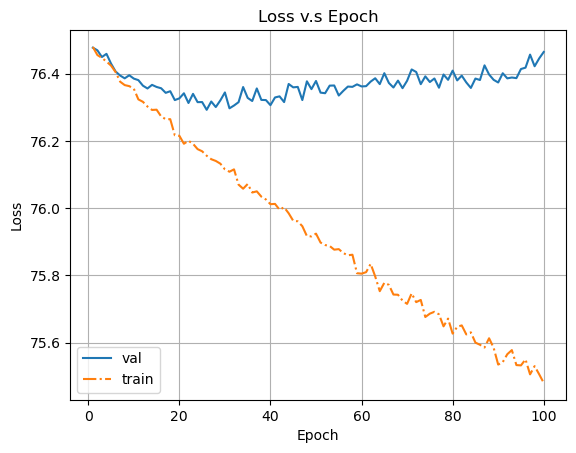

In [24]:
print(validation_data)
x = [i+1 for i in range(len(validation_data))]

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Loss v.s Epoch')
plt.grid()

plt.show()